In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from models import NormalizingFlow, MoG
from utils_plot import plot_density, grab

In [2]:
dim = 2
n_blocks = 2

model = NormalizingFlow(dim, n_blocks, 
                        hidden_dim=124,
                        hidden_activation=torch.relu)

In [3]:
x = torch.randn(5, dim)
y, log_det = model.forward(x)
x_recon, log_det_ = model.backward(y)

In [4]:
print(x)
print(y)
print(x_recon)


tensor([[-1.0961,  0.7482],
        [ 0.5914,  0.0615],
        [-0.9880,  0.7341],
        [ 0.4684,  0.2935],
        [ 0.8319, -1.3150]])
tensor([[-1.0961,  0.7482],
        [ 0.5914,  0.0615],
        [-0.9880,  0.7341],
        [ 0.4684,  0.2935],
        [ 0.8319, -1.3150]], grad_fn=<MulBackward0>)
tensor([[-1.0961,  0.7482],
        [ 0.5914,  0.0615],
        [-0.9880,  0.7341],
        [ 0.4684,  0.2935],
        [ 0.8319, -1.3150]], grad_fn=<SubBackward0>)


/Users/marylou/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180852547/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


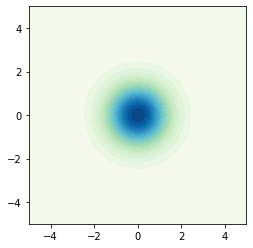

In [5]:
plot_density(model.log_prob)

In [6]:
pos = 1 # position of Gaussian components
scale = 0.1 # scale of Gaussian components
covars = [torch.eye(2) * scale, torch.eye(2) * scale]
means = [torch.tensor([-pos, - pos]), torch.tensor([pos, pos])]
target = MoG(means, covars, weights=[0.25, 0.75])

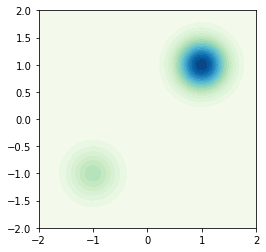

In [7]:
lims = {'x_min': 2 * - pos, 'x_max': 2 * pos, 'y_min': - 2 * pos, 'y_max': 2 * pos}
plot_density(target.log_prob, lims=lims)

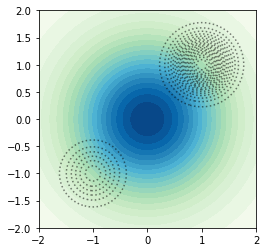

In [8]:
plot_density(model.log_prob, target.log_prob, lims=lims)

In [10]:
batch_size = 100

def kl_divergence():
    x = model.sample(batch_size)
    return (model.log_prob(x) - target.log_prob(x)).mean()

def train(model, n_epochs=100, lr=1e-3):
    plt.figure(figsize=(20, 8))
    axs = [plt.subplot(2, 5, i) for i in range(1, 11)]
    models = []
    losses = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = kl_divergence()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
       
        if epoch % (n_epochs/10) == 0:
            print(f'Epoch {epoch}: {loss.item()}')
            ax_index = int(epoch // (n_epochs/10))
            plot_density(model.log_prob, target.log_prob, lims=lims, 
                         ax=axs[ax_index], title=f'Epoch {epoch}')
    return losses
                    

Epoch 0: 6.210127353668213
Epoch 5: 5.53225040435791
Epoch 10: 4.1186747550964355
Epoch 15: 2.9668281078338623
Epoch 20: 2.376924991607666
Epoch 25: 1.8979300260543823
Epoch 30: 1.2256360054016113
Epoch 35: 1.0809967517852783
Epoch 40: 1.1089911460876465
Epoch 45: 1.1838449239730835


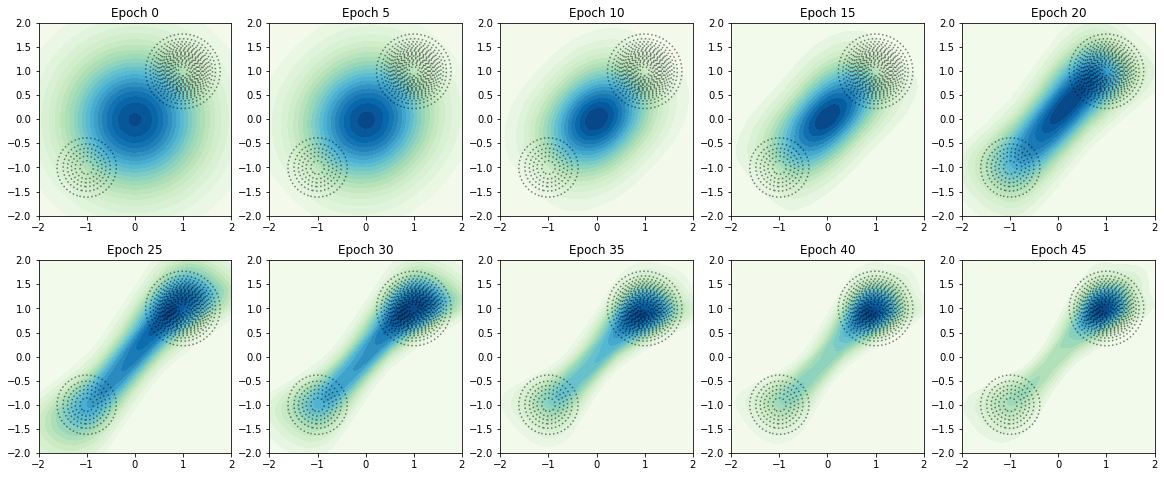

In [14]:
torch.manual_seed(10)  #fix seed for reproducibility/comment for random initialization
dim = 2
n_blocks = 2
model = NormalizingFlow(dim, n_blocks, 
                        hidden_dim=124,
                        hidden_activation=torch.relu)

losses = train(model, n_epochs=50, lr=5e-3) 
# increase to 500 iterations to get better results 

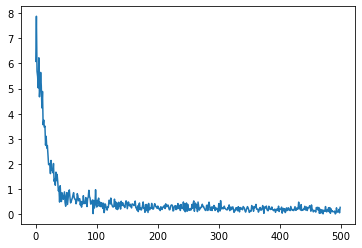

In [12]:
plt.plot(losses)

## Use for sampling - Importance samping

- Draw from the normalizing flow model $x_i \sim \rho_\theta(x)$

- Compute importance weights $w_i = \frac{\rho_*(x_i)}{\rho_\theta(x_i)}$

- Approximate thermodynamic averages $\displaystyle \langle \mathcal{O}(x) \rangle_* \approx \sum_{i = 1}^N \frac{w_i \mathcal{O}(x_i)}{\sum_{j=1}^N w_j}  $


(-2.0, 2.0)

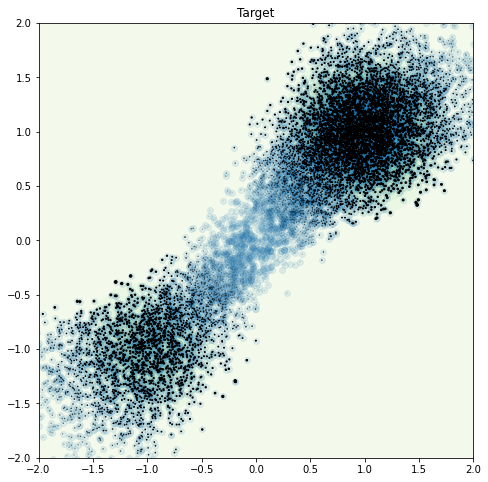

In [27]:
xs = model.sample(10000)
log_ws = target.log_prob(xs) - model.log_prob(xs)  

plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
plot_density(target.log_prob, lims=lims, ax=ax, title='Target')
plt.scatter(grab(xs[:, 0]), grab(xs[:, 1]), alpha=0.1) #, s=grab(torch.exp(log_ws)), c='k')
plt.scatter(grab(xs[:, 0]), grab(xs[:, 1]), s=grab(torch.exp(log_ws)), c='k')
plt.gca().set_xlim(lims['x_min'], lims['x_max'])
plt.gca().set_ylim(lims['y_min'], lims['y_max'])


To normalize the weights, we should use the numerically stable [`logsumexp`](https://pytorch.org/docs/stable/generated/torch.logsumexp.html):

In [34]:
log_normalized_ws = log_ws - torch.logsumexp(log_ws, dim=0)
normalized_ws = torch.exp(log_normalized_ws)

By summing the corresponding weights, we can compute the weight of each Gaussian component:

In [40]:
weight_mode_pos = normalized_ws[(xs[:, 0] > 0) * (xs[:, 1] > 0)].sum()
print('We predict a weight for the mode in the positive cadrant of:', weight_mode_pos.item())

We predict a weight for the mode in the positive cadrant of: 0.7525408267974854


## What is the relative weight of the upper mode for this 1d phi_4 with local field blublu? 

## Markov Chain Monte Carlo

To do sketch an enoncé